In [1]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import requests
import pandas as pd 
#import io
import numpy as np
import statsmodels.api as sm
#from IPython.display import display, Markdown, Latex

/Users/Myworld/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [20]:
## figure configurations 

figsize = (12,5)
fontsize = 10

outsample_time = datetime.datetime(2020, 2, 1)

## unemployement rate data 

In [21]:
start = datetime.datetime(1960, 1, 30)
end = datetime.datetime(2020, 3, 30)

## get unemployment rate from Fred 

ue = web.DataReader('UNRATE', 'fred', start, end)

In [22]:
ue.index = pd.DatetimeIndex(pd.to_datetime(ue.index,
                                           format = '%Y-%m-%d'),
                                  freq = 'infer')
ue.index.name = None

ue = ue.rename(columns = {'UNRATE':'ue'})

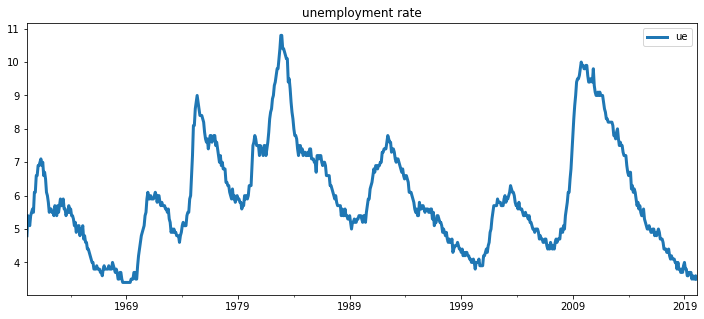

In [23]:
ue.plot(lw = 3,
        figsize = figsize,
        title = 'unemployment rate')
plt.savefig('figures/ue')

## Retail series (excluding vehicles and gas) 

In [24]:
## downloading data from fred 

retail = web.DataReader('MARTSSM44W72USS', 'fred', start, end)
pce_idx = web.DataReader('PCEPI', 'fred', start, end)

retail.index = pd.DatetimeIndex(pd.to_datetime(retail.index,
                                               format = '%Y-%m-%d'),
                                freq = 'MS')

retail = retail.rename(columns={'MARTSSM44W72USS':'retail'})

pce_idx.index = pd.DatetimeIndex(pd.to_datetime(pce_idx.index,
                                               format = '%Y-%m-%d'),
                                freq = 'infer')
retail.index.name = None
pce_idx.index.name = None

## converting from nominal to real  

retail_pce = pd.merge(retail,
                      pce_idx,
                      left_index = True,
                      right_index = True)

In [25]:
retail_pce['deflator'] = retail_pce['PCEPI']/retail_pce['PCEPI'][0]
retail_pce['retail_real'] = retail_pce['retail']/retail_pce['deflator']
retail_pce['lretail_real'] = np.log(retail_pce['retail_real'])
retail_pce['retail_yoy'] = retail_pce['lretail_real'].diff(periods = 12)*100
retail = retail_pce['retail_yoy']

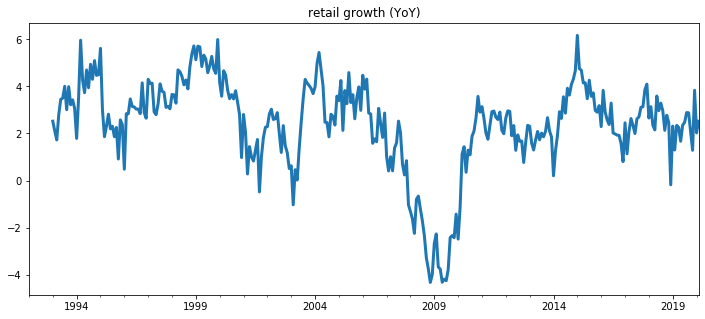

In [26]:
retail.plot(lw = 3,
        figsize = figsize,
        title = 'retail growth (YoY)')
plt.savefig('figures/retail')

## Combine all series 

In [27]:
df = pd.merge(ue,
              retail,
              left_index = True,
              right_index = True,
              how = 'outer')

In [28]:
df.columns

Index(['ue', 'retail_yoy'], dtype='object')

In [29]:
df['ue_chg'] = df['ue'].diff(periods = 12)

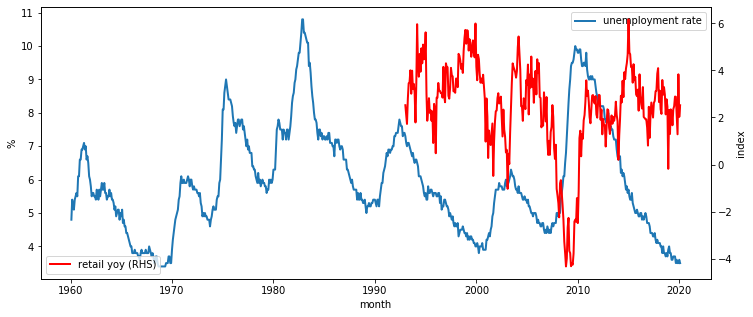

In [30]:
## plot all series 

fig, ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax.plot(df.index,
        df['ue'],
        lw =2, 
        label = 'unemployment rate')

ax2.plot(df.index,
        df['retail_yoy'],
        'r-',
        lw = 2, 
        label = 'retail yoy (RHS)')

ax.set_xlabel("month",fontsize = fontsize)
ax.set_ylabel('%',fontsize = fontsize)
ax2.set_ylabel('index',fontsize = fontsize)

ax.legend(loc = 0,
          fontsize = fontsize)
ax2.legend(loc = 3,
          fontsize = fontsize)
plt.savefig('figures/retail_yoy_ue')

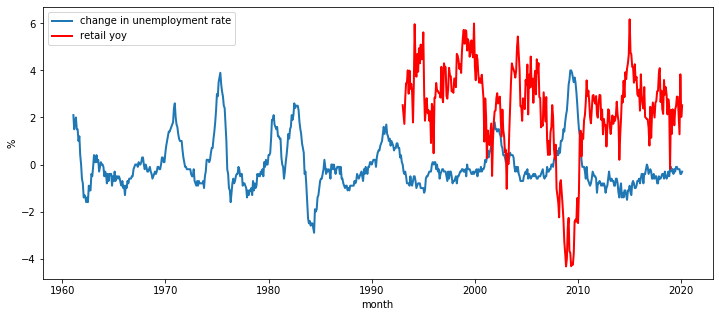

In [31]:
## change to change 

## plot all series 

fig, ax = plt.subplots(figsize = figsize)

#ax2 = ax.twinx()
ax.plot(df.index,
        df['ue_chg'],
        lw =2, 
        label = 'change in unemployment rate')

ax.plot(df.index,
        df['retail_yoy'],
        'r-',
        lw = 2, 
        label = 'retail yoy')

ax.set_xlabel("month",fontsize = fontsize)
ax.set_ylabel('%',fontsize = fontsize)
ax2.set_ylabel('index',fontsize = fontsize)

ax.legend(loc = 0,
          fontsize = fontsize)
ax2.legend(loc = 3,
          fontsize = fontsize)
plt.savefig('figures/retail_yoy_ue_chg')

## Regression: retail and unemployment rate

## Model 

\begin{eqnarray}
\newcommand{\Retail}{\texttt{log RS}}
\Retail_{t+12} - \Retail_{t}  = & \gamma_{0} + \gamma_{1} {U}_{t+12} & \text{Over history to 2019-JAN}
\end{eqnarray}

where 
  - $\texttt{log RS}$ is retail sales excluding vehicles and gas

In [32]:
## write the function of predicting retail sales using unemployment rate 

def predict_rs_yoy(ue_chg,
                   coefs):
    predict_values = coefs[0] + (coefs[1]*ue_chg.T)
    return predict_values

## Regression

In [33]:
## regress retail and unemployment rate changes 

## ols regression
df_short = df[['retail_yoy','ue_chg']].dropna(how ='any')

Y = np.array(df_short['retail_yoy'])
X = np.array(df_short['ue_chg'])
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     325.5
Date:                Wed, 01 Apr 2020   Prob (F-statistic):           7.34e-51
Time:                        09:18:19   Log-Likelihood:                -569.48
No. Observations:                 326   AIC:                             1143.
Df Residuals:                     324   BIC:                             1151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1886      0.078     28.065      0.0

In [34]:
coefs = results.params
r2 = round(results.rsquared,3)

print('Estimated coefficients:')
print(coefs)

print('R-squared:')
print(r2)

Estimated coefficients:
[ 2.18856615 -1.46219231]
R-squared:
0.501


In [35]:
## predict the rs changes using change in UE

rs_yoy_ue_prd = predict_rs_yoy(np.array(df['ue_chg'].dropna(how ='any')),
                               coefs)  ## plug the estimated coefficients 

rs_yoy_index = df['ue_chg'].dropna(how ='any').index  # two months in the end are out of sample.

prd_df = pd.DataFrame(rs_yoy_ue_prd,
                      columns = ['rs_yoyprd'],
                      index = rs_yoy_index)
df = pd.merge(df,
              prd_df,
              left_index = True,
              right_index = True,
              how = 'outer')

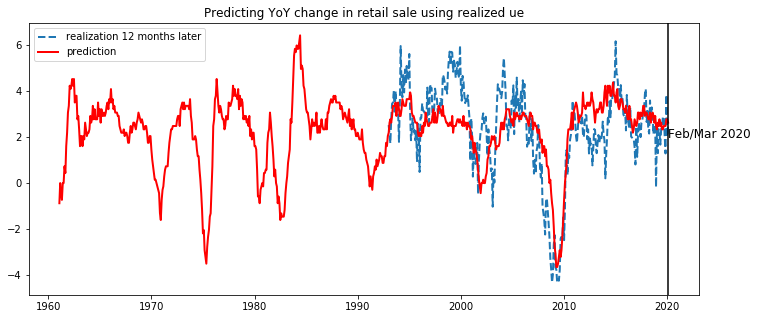

In [36]:
fig = plt.figure(figsize = figsize)
plt.plot(rs_yoy_index,
         np.array(df['retail_yoy'].loc[rs_yoy_index]),
         '--',
         lw = 2, 
         label = 'realization 12 months later')
plt.plot(rs_yoy_index,
         rs_yoy_ue_prd,
         'r-',
         lw = 2,
         label='prediction')
plt.title('Predicting YoY change in retail sale using realized ue')
plt.axvline(x = outsample_time,
            color = 'black')
plt.text(outsample_time, 2, 'Feb/Mar 2020', fontsize = 12)  # mark the out-of-sample prediction
plt.legend(loc = 2)
plt.savefig('figures/rs_yoy_predict_ue')

## Prediction 

Let us consider that there will be unemployment rate after the shock, what does it mean to have 

In [37]:
last_ob_date = datetime.datetime(2019, 3, 1)


u_possible = np.array((5,10,15,20,25))
n_possible = len(u_possible)

u_chg_possible = np.linspace(5,40,7) - df['ue'].loc[last_ob_date]
rs_yoy_predict = np.empty(n_possible)

for i in range(n_possible):
    rs_yoy_predict[i] = predict_rs_yoy(u_chg_possible[i],
                                       coefs)
    

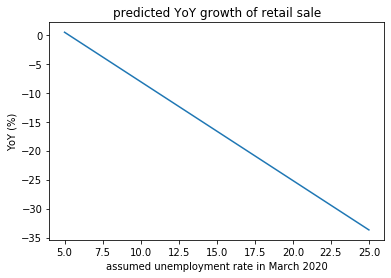

In [41]:
plt.plot(u_possible,
        rs_yoy_predict)
plt.title('predicted YoY growth of retail sale')
plt.xlabel('assumed unemployment rate in March 2020')
plt.ylabel('YoY (%)')
plt.savefig('figures/predicted_rs_different_ues')